# Credit Scoring Model - Prediction & Evaluation

## Third Version Dataset (2022-2024)

This notebook loads the trained models and evaluates their performance on the new dataset.

**Datasets:**
- Train: `data/third_version/TRAIN_DATAMART_2022_2024.csv` (81,833 samples)
- Test: `data/third_version/TEST_DATAMART_2022_2024.csv` (14,924 samples)

**Models:**
- Baseline: `outputs/credit_scoring_model.pkl`
- Optimized: `outputs/credit_scoring_model_optimized.pkl`

## 1. Setup & Configuration

In [1]:
import pandas as pd
import numpy as np
import pickle
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, brier_score_loss, log_loss
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration
TRAIN_PATH = 'data/third_version/TRAIN_DATAMART_2022_2024.csv'
TEST_PATH = 'data/third_version/TEST_DATAMART_2022_2024.csv'
BASELINE_MODEL_PATH = 'outputs/credit_scoring_model.pkl'
OPTIMIZED_MODEL_PATH = 'outputs/credit_scoring_model_optimized.pkl'
OUTPUT_DIR = 'outputs'

TARGET_COL = 'TARGET'
ID_COL = 'MUQAVILE'

print("Configuration loaded successfully")

Configuration loaded successfully


In [2]:
# Define Pipeline Classes (required for unpickling model artifacts)

class DataPreprocessor:
    """Stage 1: Data cleaning and preprocessing"""
    def __init__(self, target_col, id_col, null_threshold=0.95):
        self.target_col = target_col
        self.id_col = id_col
        self.null_threshold = null_threshold
        self.cols_to_drop = []
        self.categorical_cols = []
        self.numeric_cols = []

    def fit(self, df):
        self.cols_to_drop = [self.id_col] if self.id_col in df.columns else []
        null_rates = df.isnull().mean()
        high_null_cols = null_rates[null_rates > self.null_threshold].index.tolist()
        self.cols_to_drop.extend(high_null_cols)
        remaining_cols = [c for c in df.columns if c not in self.cols_to_drop and c != self.target_col]
        self.categorical_cols = df[remaining_cols].select_dtypes(include=['object']).columns.tolist()
        self.numeric_cols = df[remaining_cols].select_dtypes(include=['number']).columns.tolist()
        return self

    def transform(self, df):
        return df.drop(columns=[c for c in self.cols_to_drop if c in df.columns], errors='ignore')

    def fit_transform(self, df):
        return self.fit(df).transform(df)


class WOEBinner:
    """Stage 2: Weight of Evidence transformation"""
    def __init__(self, max_bins=10, min_samples_bin=0.05, random_state=42):
        self.max_bins = max_bins
        self.min_samples_bin = min_samples_bin
        self.random_state = random_state
        self.binning_tables = {}
        self.iv_values = {}

    def _bin_numeric(self, series, target_series):
        is_null = series.isnull()
        non_null_series = series[~is_null]
        if len(non_null_series) == 0:
            return pd.Series(['MISSING'] * len(series), index=series.index), {'MISSING': (-np.inf, np.inf)}
        n_unique = non_null_series.nunique()
        n_bins = min(self.max_bins, n_unique)
        if n_bins <= 1:
            binned = pd.Series(['BIN_1'] * len(series), index=series.index)
            binned[is_null] = 'MISSING'
            return binned, {'BIN_1': (non_null_series.min(), non_null_series.max()), 'MISSING': (np.nan, np.nan)}
        try:
            binned_non_null, bin_edges = pd.qcut(non_null_series, q=n_bins, retbins=True, duplicates='drop')
            categories = binned_non_null.cat.categories
            binned_non_null = binned_non_null.astype(str)
        except ValueError:
            try:
                binned_non_null, bin_edges = pd.cut(non_null_series, bins=min(5, n_unique), retbins=True, duplicates='drop')
                categories = binned_non_null.cat.categories
                binned_non_null = binned_non_null.astype(str)
            except:
                binned = pd.Series(['BIN_1'] * len(series), index=series.index)
                binned[is_null] = 'MISSING'
                return binned, {'BIN_1': (series.min(), series.max()), 'MISSING': (np.nan, np.nan)}
        binned = pd.Series(index=series.index, dtype=str)
        binned[~is_null] = binned_non_null
        binned[is_null] = 'MISSING'
        bins_dict = {str(cat): (bin_edges[i], bin_edges[i+1]) for i, cat in enumerate(categories) if i < len(bin_edges)-1}
        bins_dict['MISSING'] = (np.nan, np.nan)
        return binned, bins_dict

    def _bin_categorical(self, series):
        return series.fillna('MISSING').astype(str)

    def transform(self, X):
        X_woe = pd.DataFrame(index=X.index)
        for col, binning_info in self.binning_tables.items():
            if col not in X.columns:
                continue
            if binning_info['type'] == 'numeric':
                binned, _ = self._bin_numeric(X[col], pd.Series([0]*len(X)))
            else:
                binned = self._bin_categorical(X[col])
            woe_map = binning_info['woe_map']
            default_woe = np.mean(list(woe_map.values()))
            X_woe[f'{col}_woe'] = binned.map(woe_map).fillna(default_woe)
        return X_woe


class FeatureSelector:
    """Stage 3: Unified Feature Selection"""
    def __init__(self, min_iv=0.02, max_iv=0.5, min_gini=0.01, max_corr=0.85, min_target_corr=0.001, random_state=42):
        self.min_iv = min_iv
        self.max_iv = max_iv
        self.min_gini = min_gini
        self.max_corr = max_corr
        self.min_target_corr = min_target_corr
        self.random_state = random_state
        self.selected_features = []
        self.feature_stats = None
        self.elimination_log = {}

    def transform(self, X_woe):
        available = [f for f in self.selected_features if f in X_woe.columns]
        return X_woe[available].copy()

print("Pipeline classes defined successfully")

Pipeline classes defined successfully


## 2. Load Models

In [3]:
# Load baseline model
print("Loading baseline model...")
with open(BASELINE_MODEL_PATH, 'rb') as f:
    baseline_artifacts = pickle.load(f)

baseline_model = baseline_artifacts['model']
preprocessor = baseline_artifacts['preprocessor']
woe_binner = baseline_artifacts['woe_binner']
feature_selector = baseline_artifacts['feature_selector']

print(f"  - Model type: {type(baseline_model).__name__}")
print(f"  - Selected features: {len(feature_selector.selected_features)}")

# Load optimized model
print("\nLoading optimized model...")
with open(OPTIMIZED_MODEL_PATH, 'rb') as f:
    optimized_artifacts = pickle.load(f)

optimized_model = optimized_artifacts['model']
is_calibrated = optimized_artifacts.get('is_calibrated', False)
best_params = optimized_artifacts.get('best_params', {})

print(f"  - Model type: {type(optimized_model).__name__}")
print(f"  - Calibrated: {is_calibrated}")
print(f"  - Best params: {best_params}")

print("\nModels loaded successfully!")

Loading baseline model...


  - Model type: LogisticRegression
  - Selected features: 238

Loading optimized model...


  - Model type: CalibratedClassifierCV
  - Calibrated: True
  - Best params: {'C': 0.004693507378665558, 'penalty': 'elasticnet', 'l1_ratio': 0.5871225558506931}

Models loaded successfully!


## 3. Load Third Version Data

In [4]:
# Column mapping for third version data
# These columns have different names in v3 but represent the same features
COLUMN_MAPPING = {
    'IbsWorkPositionType': 'WORKGROUP',
    'IbsWorkSegment': 'SAHƏLƏR',
    'LopWorkGroup': 'PARTNYORLUQ'
}

# Load datasets
print("Loading third version datasets...")

train_df = pd.read_csv(TRAIN_PATH, sep=';', encoding='utf-8-sig')
test_df = pd.read_csv(TEST_PATH, sep=';', encoding='utf-8-sig')

# Apply column mapping
print(f"\nApplying column mapping:")
for old_name, new_name in COLUMN_MAPPING.items():
    if old_name in train_df.columns:
        train_df = train_df.rename(columns={old_name: new_name})
        test_df = test_df.rename(columns={old_name: new_name})
        print(f"  {old_name} -> {new_name}")

print(f"\nTrain dataset: {train_df.shape[0]:,} samples, {train_df.shape[1]:,} features")
print(f"Test dataset: {test_df.shape[0]:,} samples, {test_df.shape[1]:,} features")

# Check target distribution
print(f"\n=== Target Distribution ===")
print(f"\nTrain set:")
print(train_df[TARGET_COL].value_counts())
print(f"Target rate: {train_df[TARGET_COL].mean()*100:.2f}%")

print(f"\nTest set:")
print(test_df[TARGET_COL].value_counts())
print(f"Target rate: {test_df[TARGET_COL].mean()*100:.2f}%")

# Combined
combined_df = pd.concat([train_df, test_df], ignore_index=True)
print(f"\nCombined dataset: {combined_df.shape[0]:,} samples")
print(f"Combined target rate: {combined_df[TARGET_COL].mean()*100:.2f}%")

# Check which features are still missing
missing_check = ['SAHƏLƏR', 'PARTNYORLUQ', 'WORKGROUP', 'BGN']
print(f"\n=== Feature Availability Check ===")
for feat in missing_check:
    status = "Available" if feat in train_df.columns else "MISSING"
    print(f"  {feat}: {status}")

Loading third version datasets...



Applying column mapping:


  IbsWorkPositionType -> WORKGROUP


  IbsWorkSegment -> SAHƏLƏR


  LopWorkGroup -> PARTNYORLUQ

Train dataset: 81,833 samples, 2,738 features
Test dataset: 14,924 samples, 2,738 features

=== Target Distribution ===

Train set:
TARGET
0    81131
1      702
Name: count, dtype: int64
Target rate: 0.86%

Test set:
TARGET
0    14783
1      141
Name: count, dtype: int64
Target rate: 0.94%



Combined dataset: 96,757 samples
Combined target rate: 0.87%

=== Feature Availability Check ===
  SAHƏLƏR: Available
  PARTNYORLUQ: Available
  WORKGROUP: Available
  BGN: MISSING


## 4. Data Preprocessing

In [5]:
def process_data(df, preprocessor, woe_binner, feature_selector):
    """
    Process data through the trained pipeline.
    """
    # Step 1: Preprocess (remove ID, handle nulls)
    df_clean = preprocessor.transform(df)
    
    # Step 2: Extract features and target
    X = df_clean.drop(columns=[TARGET_COL], errors='ignore')
    y = df_clean[TARGET_COL] if TARGET_COL in df_clean.columns else None
    
    # Step 3: WOE transformation
    X_woe = woe_binner.transform(X)
    
    # Step 4: Feature selection
    X_selected = feature_selector.transform(X_woe)
    
    # Step 5: Handle missing values
    X_final = X_selected.fillna(0)
    
    # Step 6: Add missing features that were in training but not in this data
    missing_features = set(feature_selector.selected_features) - set(X_final.columns)
    if missing_features:
        print(f"  Warning: {len(missing_features)} features missing from data, filling with 0")
        for feat in missing_features:
            X_final[feat] = 0
        # Reorder columns to match training
        X_final = X_final[feature_selector.selected_features]
    
    return X_final, y

# Process train and test sets
print("Processing train set...")
X_train, y_train = process_data(train_df, preprocessor, woe_binner, feature_selector)
print(f"  Shape: {X_train.shape}")

print("\nProcessing test set...")
X_test, y_test = process_data(test_df, preprocessor, woe_binner, feature_selector)
print(f"  Shape: {X_test.shape}")

# Process combined
print("\nProcessing combined set...")
X_combined, y_combined = process_data(combined_df, preprocessor, woe_binner, feature_selector)
print(f"  Shape: {X_combined.shape}")

print("\nData processing completed!")

Processing train set...


  Shape: (81833, 238)

Processing test set...


  Shape: (14924, 238)

Processing combined set...


  Shape: (96757, 238)

Data processing completed!


## 5. Generate Predictions

In [6]:
def gini_score(y_true, y_pred):
    """Calculate Gini coefficient"""
    return 2 * roc_auc_score(y_true, y_pred) - 1

# Generate predictions for all datasets
datasets = {
    'Train': (X_train, y_train),
    'Test': (X_test, y_test),
    'Combined': (X_combined, y_combined)
}

predictions = {}

for name, (X, y) in datasets.items():
    print(f"\nGenerating predictions for {name} set...")
    
    # Baseline predictions
    pred_baseline = baseline_model.predict_proba(X)[:, 1]
    
    # Optimized predictions
    pred_optimized = optimized_model.predict_proba(X)[:, 1]
    
    predictions[name] = {
        'baseline': pred_baseline,
        'optimized': pred_optimized,
        'y_true': y
    }
    
    print(f"  Baseline - Min: {pred_baseline.min():.4f}, Max: {pred_baseline.max():.4f}, Mean: {pred_baseline.mean():.4f}")
    print(f"  Optimized - Min: {pred_optimized.min():.4f}, Max: {pred_optimized.max():.4f}, Mean: {pred_optimized.mean():.4f}")

print("\nPredictions generated successfully!")


Generating predictions for Train set...


  Baseline - Min: 0.0132, Max: 0.9112, Mean: 0.2265
  Optimized - Min: 0.0007, Max: 0.0584, Mean: 0.0097

Generating predictions for Test set...
  Baseline - Min: 0.0122, Max: 0.9198, Mean: 0.2341
  Optimized - Min: 0.0007, Max: 0.0654, Mean: 0.0096

Generating predictions for Combined set...


  Baseline - Min: 0.0085, Max: 0.8831, Mean: 0.2208
  Optimized - Min: 0.0007, Max: 0.0584, Mean: 0.0097

Predictions generated successfully!


## 6. Model Performance Evaluation

In [7]:
def evaluate_model(y_true, y_pred, model_name):
    """Calculate all evaluation metrics"""
    auc = roc_auc_score(y_true, y_pred)
    gini = 2 * auc - 1
    brier = brier_score_loss(y_true, y_pred)
    logloss = log_loss(y_true, y_pred)
    
    return {
        'Model': model_name,
        'AUC': auc,
        'Gini': gini,
        'Brier Score': brier,
        'Log Loss': logloss
    }

# Evaluate all models on all datasets
results = []

print("="*80)
print("MODEL PERFORMANCE ON THIRD VERSION DATA (2022-2024)")
print("="*80)

for dataset_name, preds in predictions.items():
    y_true = preds['y_true']
    
    print(f"\n{'='*80}")
    print(f"{dataset_name.upper()} SET RESULTS")
    print(f"{'='*80}")
    print(f"Samples: {len(y_true):,} | Target rate: {y_true.mean()*100:.2f}%")
    print("-"*80)
    
    # Evaluate baseline
    baseline_metrics = evaluate_model(y_true, preds['baseline'], 'Baseline')
    baseline_metrics['Dataset'] = dataset_name
    results.append(baseline_metrics)
    
    # Evaluate optimized
    optimized_metrics = evaluate_model(y_true, preds['optimized'], 'Optimized')
    optimized_metrics['Dataset'] = dataset_name
    results.append(optimized_metrics)
    
    # Print comparison
    print(f"{'Metric':<20} {'Baseline':<15} {'Optimized':<15} {'Difference':<15}")
    print("-"*65)
    
    for metric in ['AUC', 'Gini', 'Brier Score', 'Log Loss']:
        base_val = baseline_metrics[metric]
        opt_val = optimized_metrics[metric]
        diff = opt_val - base_val
        
        # For Brier and Log Loss, lower is better
        if metric in ['Brier Score', 'Log Loss']:
            indicator = '✓' if diff < 0 else '✗'
        else:
            indicator = '✓' if diff > 0 else '✗'
        
        print(f"{metric:<20} {base_val:<15.4f} {opt_val:<15.4f} {diff:+.4f} {indicator}")

# Create results dataframe
results_df = pd.DataFrame(results)
print("\n" + "="*80)

MODEL PERFORMANCE ON THIRD VERSION DATA (2022-2024)

TRAIN SET RESULTS
Samples: 81,833 | Target rate: 0.86%
--------------------------------------------------------------------------------
Metric               Baseline        Optimized       Difference     
-----------------------------------------------------------------
AUC                  0.6465          0.6725          +0.0260 ✓
Gini                 0.2930          0.3450          +0.0520 ✓
Brier Score          0.0744          0.0085          -0.0659 ✓
Log Loss             0.2858          0.0478          -0.2380 ✓

TEST SET RESULTS
Samples: 14,924 | Target rate: 0.94%
--------------------------------------------------------------------------------
Metric               Baseline        Optimized       Difference     
-----------------------------------------------------------------
AUC                  0.5708          0.6209          +0.0501 ✓
Gini                 0.1416          0.2418          +0.1002 ✓
Brier Score          0.0800

## 7. Performance Comparison Summary

In [8]:
# Create summary comparison table
print("\n" + "="*80)
print("PERFORMANCE SUMMARY - GINI COEFFICIENTS")
print("="*80)

summary_data = []

for dataset_name in ['Train', 'Test', 'Combined']:
    preds = predictions[dataset_name]
    y_true = preds['y_true']
    
    gini_baseline = gini_score(y_true, preds['baseline'])
    gini_optimized = gini_score(y_true, preds['optimized'])
    diff = gini_optimized - gini_baseline
    diff_pct = (diff / abs(gini_baseline)) * 100 if gini_baseline != 0 else 0
    
    summary_data.append({
        'Dataset': dataset_name,
        'Samples': len(y_true),
        'Target Rate': f"{y_true.mean()*100:.2f}%",
        'Baseline Gini': gini_baseline,
        'Optimized Gini': gini_optimized,
        'Difference': diff,
        'Change %': diff_pct
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

# Compare with original training performance
print("\n" + "="*80)
print("COMPARISON WITH ORIGINAL TRAINING RESULTS")
print("="*80)

original_metrics = optimized_artifacts.get('metrics', {})
if original_metrics:
    print(f"\n{'Dataset':<25} {'Original Gini':<18} {'Third Version Gini':<18} {'Difference':<15}")
    print("-"*75)
    
    if 'optimized' in original_metrics:
        orig_test = original_metrics['optimized'].get('test_gini', 'N/A')
        new_combined = gini_score(predictions['Combined']['y_true'], predictions['Combined']['optimized'])
        
        if isinstance(orig_test, (int, float)):
            diff = new_combined - orig_test
            print(f"{'Optimized Model':<25} {orig_test:<18.4f} {new_combined:<18.4f} {diff:+.4f}")


PERFORMANCE SUMMARY - GINI COEFFICIENTS


 Dataset  Samples Target Rate  Baseline Gini  Optimized Gini  Difference  Change %
   Train    81833       0.86%       0.292969        0.345001    0.052032 17.760198
    Test    14924       0.94%       0.141649        0.241842    0.100193 70.732996
Combined    96757       0.87%       0.240881        0.325582    0.084701 35.162786

COMPARISON WITH ORIGINAL TRAINING RESULTS

Dataset                   Original Gini      Third Version Gini Difference     
---------------------------------------------------------------------------
Optimized Model           0.4117             0.3256             -0.0861


## 8. Visualizations

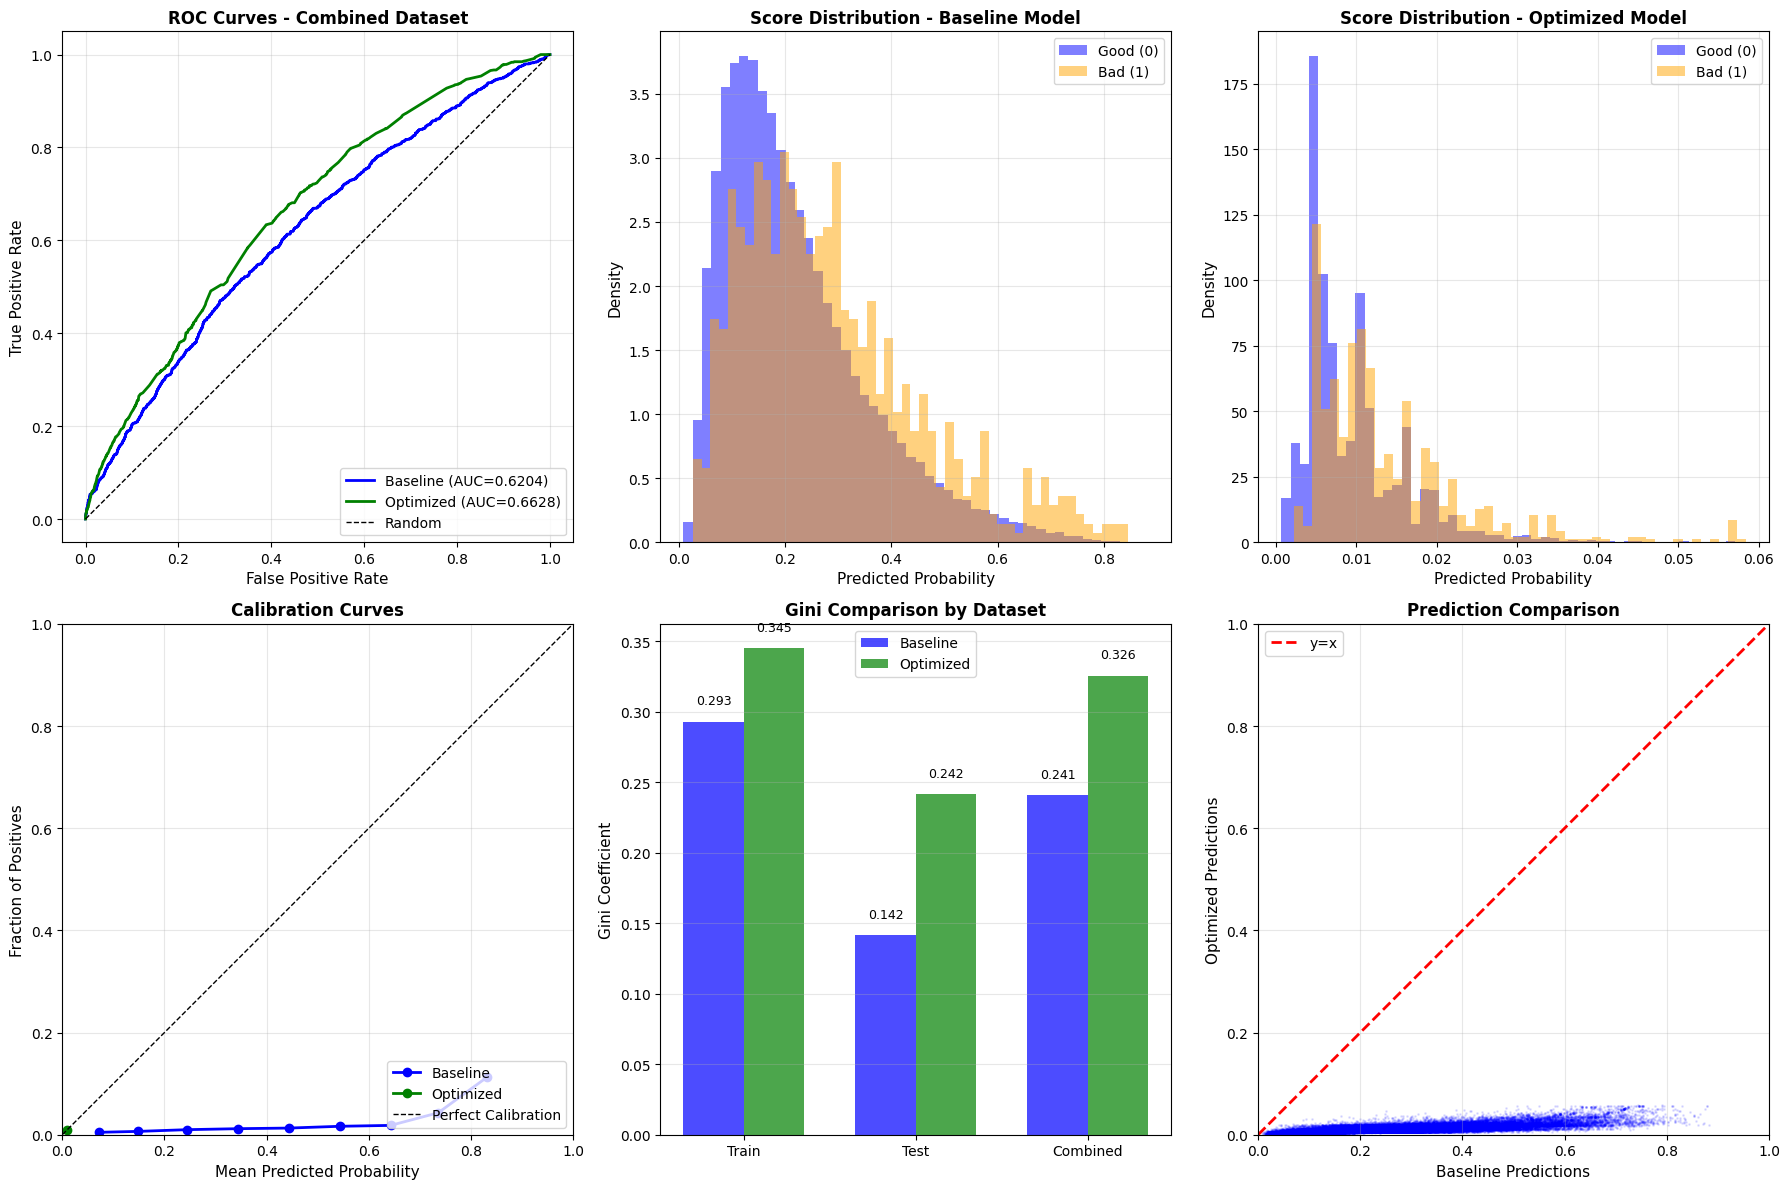


Visualization saved to 'outputs/third_version_evaluation.png'


In [9]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Use Combined dataset for visualizations
y_true = predictions['Combined']['y_true']
pred_baseline = predictions['Combined']['baseline']
pred_optimized = predictions['Combined']['optimized']

# 1. ROC Curves
ax = axes[0, 0]
for name, preds, color in [('Baseline', pred_baseline, 'blue'), 
                            ('Optimized', pred_optimized, 'green')]:
    fpr, tpr, _ = roc_curve(y_true, preds)
    auc = roc_auc_score(y_true, preds)
    ax.plot(fpr, tpr, color=color, linewidth=2, label=f'{name} (AUC={auc:.4f})')

ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
ax.set_xlabel('False Positive Rate', fontsize=11)
ax.set_ylabel('True Positive Rate', fontsize=11)
ax.set_title('ROC Curves - Combined Dataset', fontsize=12, fontweight='bold')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)

# 2. Score Distribution - Baseline
ax = axes[0, 1]
ax.hist(pred_baseline[y_true == 0], bins=50, alpha=0.5, label='Good (0)', density=True, color='blue')
ax.hist(pred_baseline[y_true == 1], bins=50, alpha=0.5, label='Bad (1)', density=True, color='orange')
ax.set_xlabel('Predicted Probability', fontsize=11)
ax.set_ylabel('Density', fontsize=11)
ax.set_title('Score Distribution - Baseline Model', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Score Distribution - Optimized
ax = axes[0, 2]
ax.hist(pred_optimized[y_true == 0], bins=50, alpha=0.5, label='Good (0)', density=True, color='blue')
ax.hist(pred_optimized[y_true == 1], bins=50, alpha=0.5, label='Bad (1)', density=True, color='orange')
ax.set_xlabel('Predicted Probability', fontsize=11)
ax.set_ylabel('Density', fontsize=11)
ax.set_title('Score Distribution - Optimized Model', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# 4. Calibration Curves
ax = axes[1, 0]
for name, preds, color in [('Baseline', pred_baseline, 'blue'), 
                            ('Optimized', pred_optimized, 'green')]:
    prob_true, prob_pred = calibration_curve(y_true, preds, n_bins=10, strategy='uniform')
    ax.plot(prob_pred, prob_true, marker='o', color=color, linewidth=2, label=name)

ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Perfect Calibration')
ax.set_xlabel('Mean Predicted Probability', fontsize=11)
ax.set_ylabel('Fraction of Positives', fontsize=11)
ax.set_title('Calibration Curves', fontsize=12, fontweight='bold')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

# 5. Gini by Dataset
ax = axes[1, 1]
datasets_names = ['Train', 'Test', 'Combined']
gini_baseline_vals = [gini_score(predictions[d]['y_true'], predictions[d]['baseline']) for d in datasets_names]
gini_optimized_vals = [gini_score(predictions[d]['y_true'], predictions[d]['optimized']) for d in datasets_names]

x = np.arange(len(datasets_names))
width = 0.35

bars1 = ax.bar(x - width/2, gini_baseline_vals, width, label='Baseline', color='blue', alpha=0.7)
bars2 = ax.bar(x + width/2, gini_optimized_vals, width, label='Optimized', color='green', alpha=0.7)

ax.set_ylabel('Gini Coefficient', fontsize=11)
ax.set_title('Gini Comparison by Dataset', fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(datasets_names)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, val in zip(bars1, gini_baseline_vals):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{val:.3f}', 
            ha='center', va='bottom', fontsize=9)
for bar, val in zip(bars2, gini_optimized_vals):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{val:.3f}', 
            ha='center', va='bottom', fontsize=9)

# 6. Prediction Scatter Plot
ax = axes[1, 2]
ax.scatter(pred_baseline, pred_optimized, alpha=0.1, s=1, c='blue')
ax.plot([0, 1], [0, 1], 'r--', linewidth=2, label='y=x')
ax.set_xlabel('Baseline Predictions', fontsize=11)
ax.set_ylabel('Optimized Predictions', fontsize=11)
ax.set_title('Prediction Comparison', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/third_version_evaluation.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nVisualization saved to '{OUTPUT_DIR}/third_version_evaluation.png'")

## 9. Save Predictions

In [10]:
# Save predictions for test set
test_output = pd.DataFrame({
    ID_COL: test_df[ID_COL].values,
    'prediction_baseline': predictions['Test']['baseline'],
    'prediction_optimized': predictions['Test']['optimized'],
    'actual': predictions['Test']['y_true'].values
})

test_output.to_csv(f'{OUTPUT_DIR}/third_version_test_predictions.csv', index=False)
print(f"Test predictions saved to '{OUTPUT_DIR}/third_version_test_predictions.csv'")

# Save predictions for combined set
combined_output = pd.DataFrame({
    ID_COL: combined_df[ID_COL].values,
    'prediction_baseline': predictions['Combined']['baseline'],
    'prediction_optimized': predictions['Combined']['optimized'],
    'actual': predictions['Combined']['y_true'].values
})

combined_output.to_csv(f'{OUTPUT_DIR}/third_version_combined_predictions.csv', index=False)
print(f"Combined predictions saved to '{OUTPUT_DIR}/third_version_combined_predictions.csv'")

# Save evaluation results
results_df.to_csv(f'{OUTPUT_DIR}/third_version_evaluation_results.csv', index=False)
print(f"Evaluation results saved to '{OUTPUT_DIR}/third_version_evaluation_results.csv'")

Test predictions saved to 'outputs/third_version_test_predictions.csv'


Combined predictions saved to 'outputs/third_version_combined_predictions.csv'
Evaluation results saved to 'outputs/third_version_evaluation_results.csv'


## 10. Final Summary

In [11]:
print("="*80)
print("THIRD VERSION DATA EVALUATION - FINAL SUMMARY")
print("="*80)

print(f"\n1. DATA SUMMARY:")
print(f"   - Train samples: {len(y_train):,}")
print(f"   - Test samples: {len(y_test):,}")
print(f"   - Combined samples: {len(y_combined):,}")
print(f"   - Target rate: {y_combined.mean()*100:.2f}%")

print(f"\n2. MODEL PERFORMANCE (Combined Dataset):")
combined_baseline_gini = gini_score(predictions['Combined']['y_true'], predictions['Combined']['baseline'])
combined_optimized_gini = gini_score(predictions['Combined']['y_true'], predictions['Combined']['optimized'])
combined_baseline_auc = roc_auc_score(predictions['Combined']['y_true'], predictions['Combined']['baseline'])
combined_optimized_auc = roc_auc_score(predictions['Combined']['y_true'], predictions['Combined']['optimized'])

print(f"   Baseline Model:")
print(f"     - AUC: {combined_baseline_auc:.4f}")
print(f"     - Gini: {combined_baseline_gini:.4f}")

print(f"\n   Optimized Model:")
print(f"     - AUC: {combined_optimized_auc:.4f}")
print(f"     - Gini: {combined_optimized_gini:.4f}")

diff = combined_optimized_gini - combined_baseline_gini
print(f"\n   Difference: {diff:+.4f} ({diff/abs(combined_baseline_gini)*100:+.2f}%)")

print(f"\n3. OUTPUT FILES:")
print(f"   - {OUTPUT_DIR}/third_version_test_predictions.csv")
print(f"   - {OUTPUT_DIR}/third_version_combined_predictions.csv")
print(f"   - {OUTPUT_DIR}/third_version_evaluation_results.csv")
print(f"   - {OUTPUT_DIR}/third_version_evaluation.png")

print("\n" + "="*80)
print("Evaluation completed successfully!")
print("="*80)

THIRD VERSION DATA EVALUATION - FINAL SUMMARY

1. DATA SUMMARY:
   - Train samples: 81,833
   - Test samples: 14,924
   - Combined samples: 96,757
   - Target rate: 0.87%

2. MODEL PERFORMANCE (Combined Dataset):
   Baseline Model:
     - AUC: 0.6204
     - Gini: 0.2409

   Optimized Model:
     - AUC: 0.6628
     - Gini: 0.3256

   Difference: +0.0847 (+35.16%)

3. OUTPUT FILES:
   - outputs/third_version_test_predictions.csv
   - outputs/third_version_combined_predictions.csv
   - outputs/third_version_evaluation_results.csv
   - outputs/third_version_evaluation.png

Evaluation completed successfully!
